In [27]:
from tiger.io import read_image, write_image
from tiger.resampling import pad_or_crop_image, resample_mask_itk, change_direction
import numpy as np
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt

In [3]:
img_dir = '/mnt/netcache/bodyct/experiments/vertebra_fracture_detection_t9560/datasets/verse2019/input_extra_masks'
msk_dir = '/mnt/netcache/bodyct/experiments/vertebra_fracture_detection_t9560/datasets/verse2019/output_extra_masks/vertebra_masks'
out_dir = '/mnt/netcache/bodyct/experiments/vertebra_fracture_detection_t9560/datasets/verse2019/fixed_extra_masks/'
img_paths = [os.path.join(img_dir, file) for file in sorted(os.listdir(img_dir))]
msk_paths = [os.path.join(msk_dir, file) for file in sorted(os.listdir(msk_dir)) if 'mha' in file]
out_paths = [os.path.join(out_dir, file) for file in sorted(os.listdir(out_dir)) if 'mha' in file]

verse011.mha
Original img shape: (38, 289, 289)
Fixed mask shape: (116, 275, 282)
Cropped mask shape: (38, 289, 289)


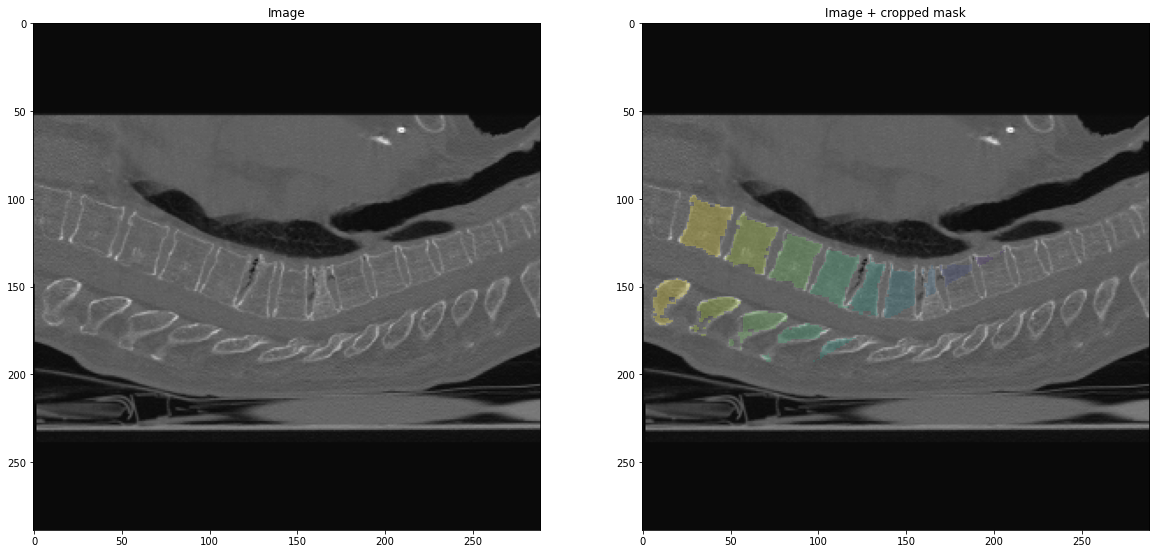

verse013.mha
Original img shape: (109, 473, 616)
Fixed mask shape: (109, 473, 616)


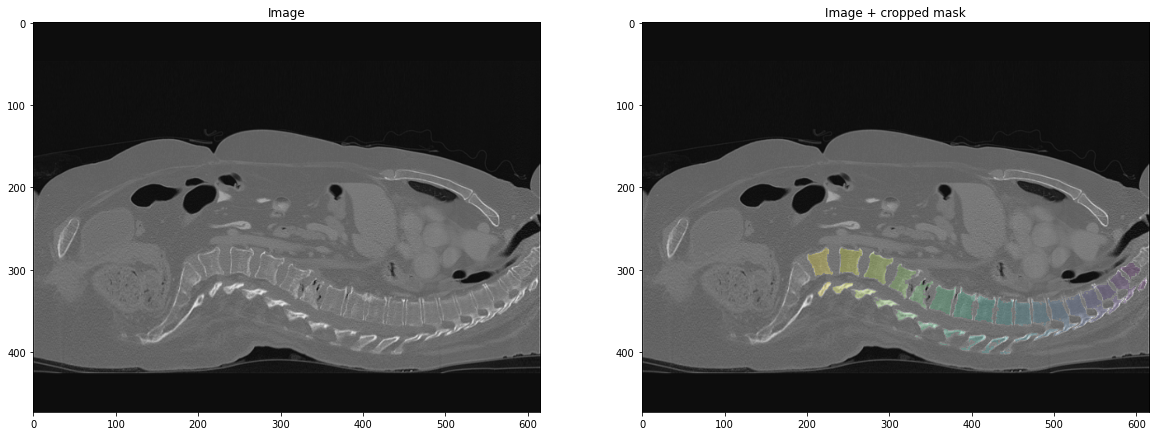

verse016.mha
Original img shape: (48, 487, 633)
Fixed mask shape: (48, 487, 633)


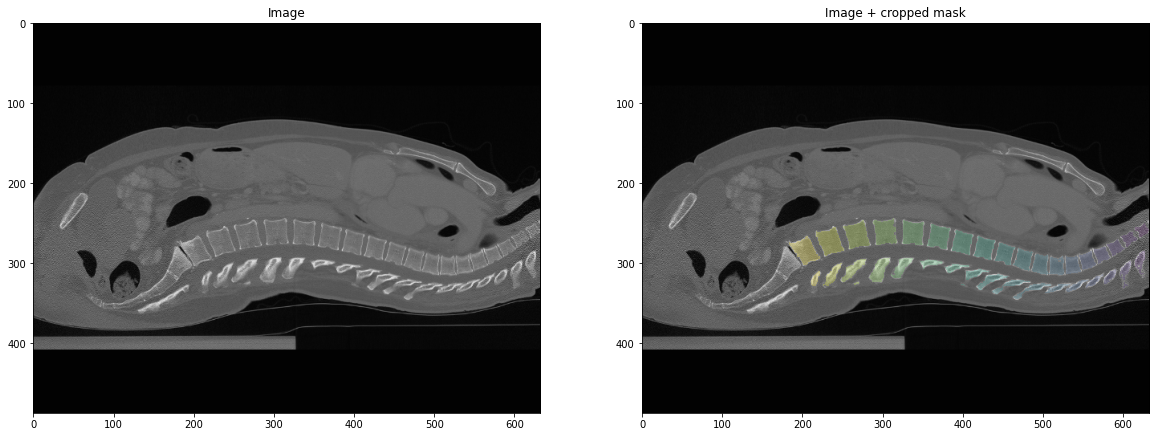

verse018.mha
Original img shape: (100, 401, 522)
Fixed mask shape: (100, 401, 522)


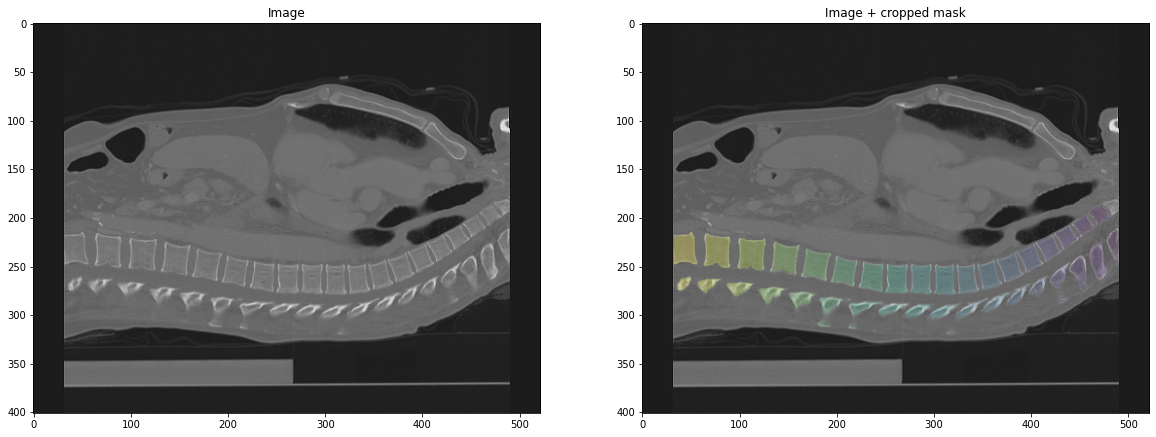

verse023.mha
Original img shape: (67, 288, 288)
Fixed mask shape: (67, 288, 288)


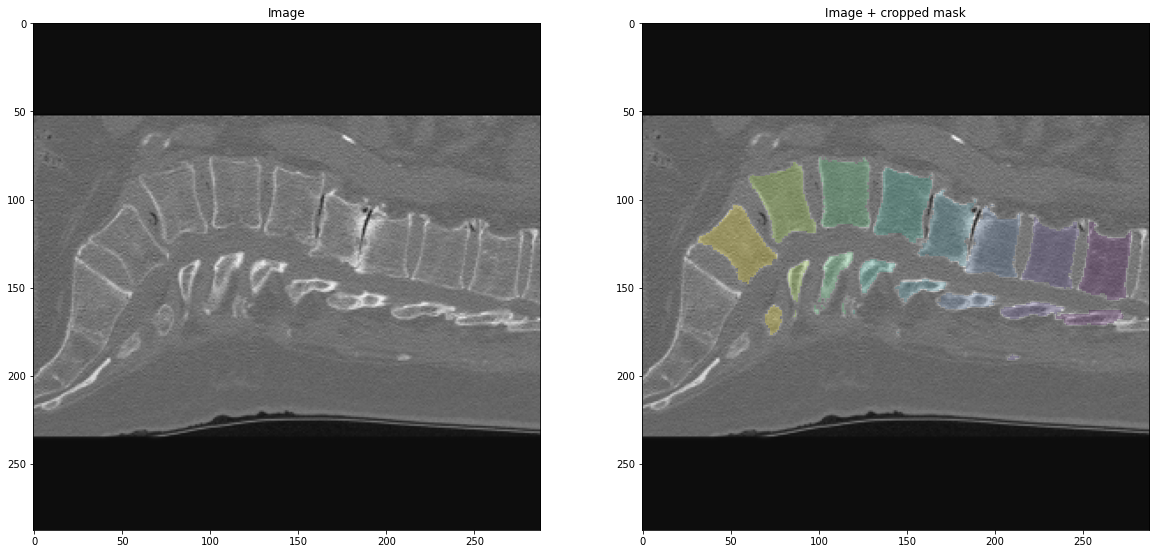

verse030.mha
Original img shape: (59, 220, 220)
Fixed mask shape: (59, 220, 220)


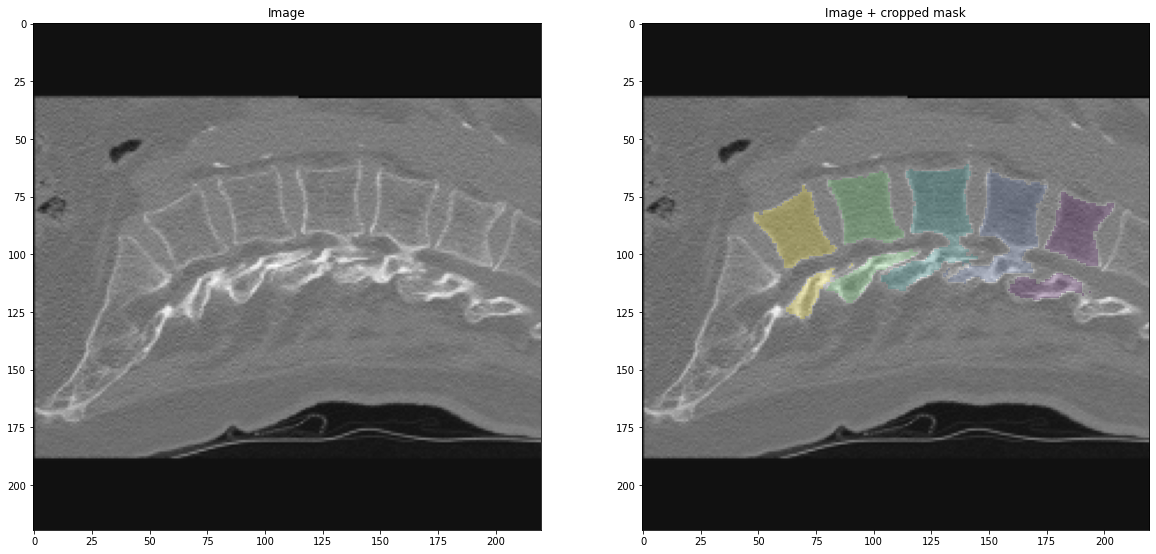

verse041.mha
Original img shape: (96, 596, 776)
Fixed mask shape: (96, 596, 776)


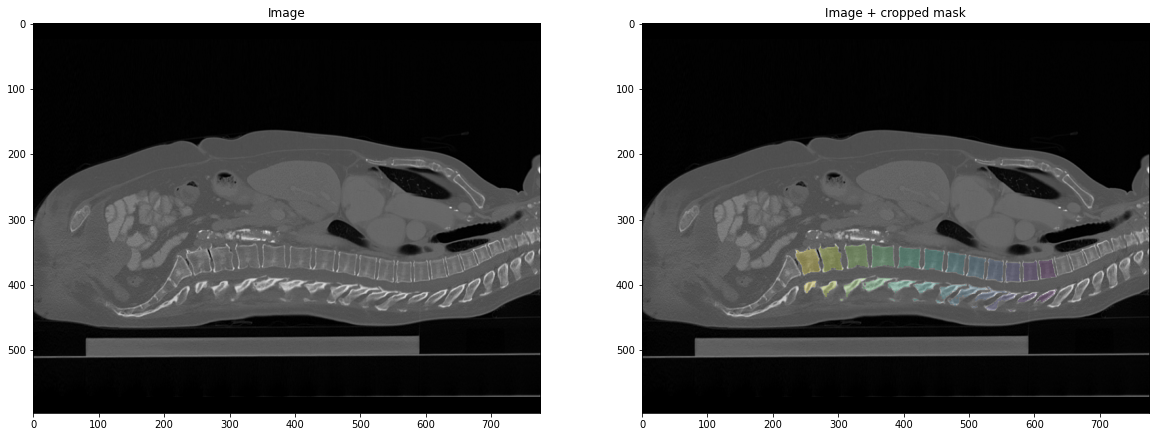

verse047.mha
Original img shape: (71, 176, 509)
Fixed mask shape: (71, 176, 509)


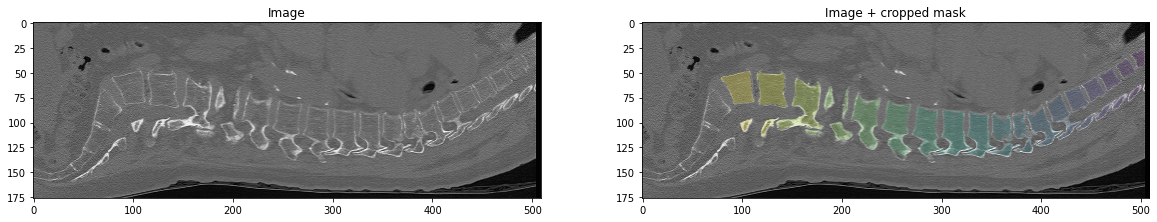

verse067.mha
Original img shape: (52, 186, 471)
Fixed mask shape: (52, 186, 471)


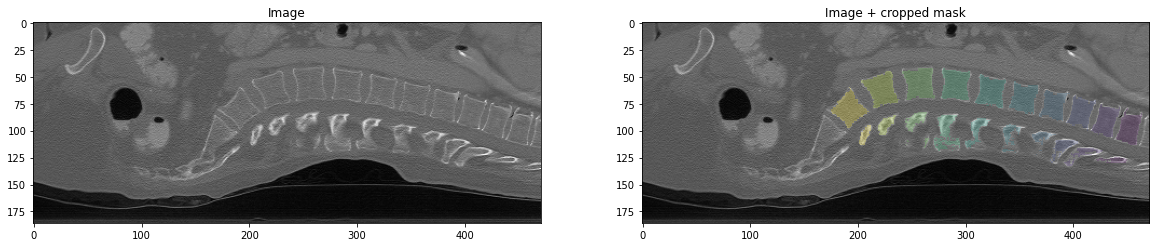

verse095.mha
Original img shape: (96, 246, 593)
Fixed mask shape: (96, 246, 593)


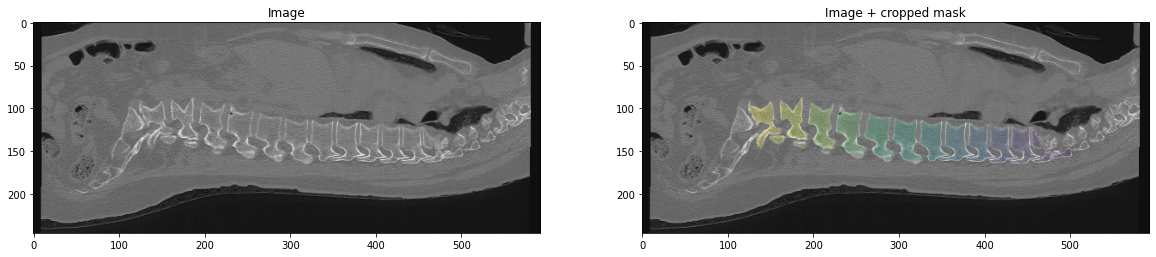

verse153.mha
Original img shape: (66, 230, 367)
Fixed mask shape: (66, 230, 367)


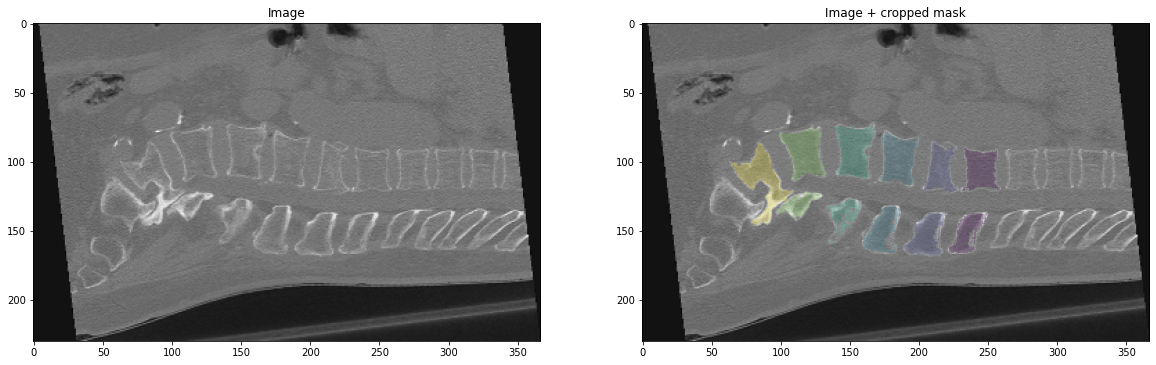

verse209.mha
Original img shape: (74, 137, 214)
Fixed mask shape: (74, 137, 214)


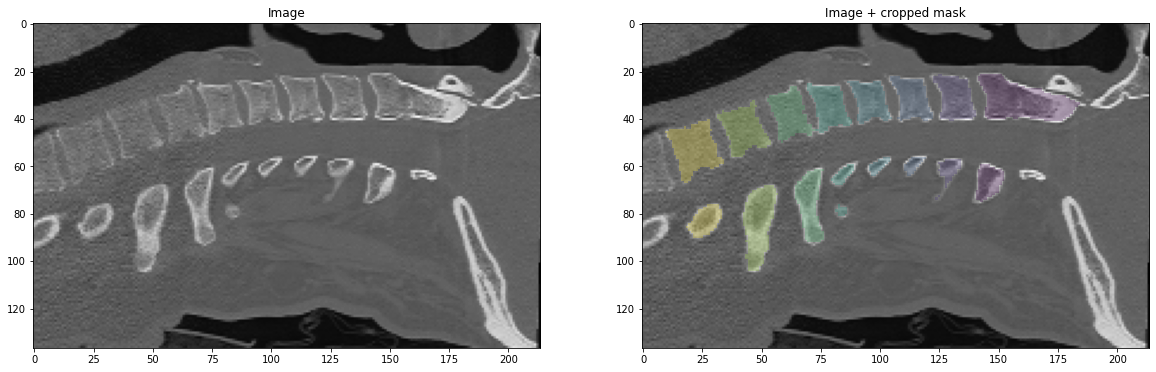

verse252.mha
Original img shape: (49, 211, 702)
Fixed mask shape: (49, 211, 702)


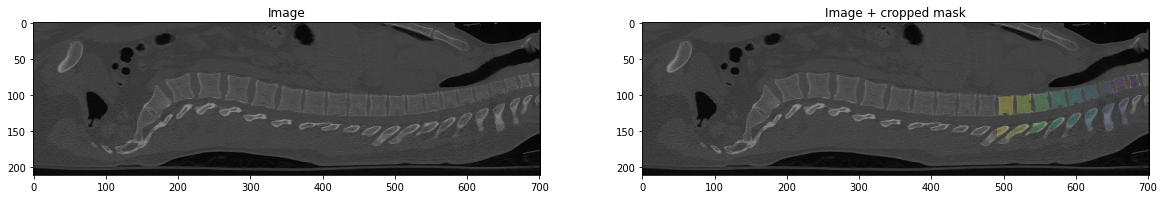

verse256.mha
Original img shape: (86, 218, 667)
Fixed mask shape: (86, 218, 667)


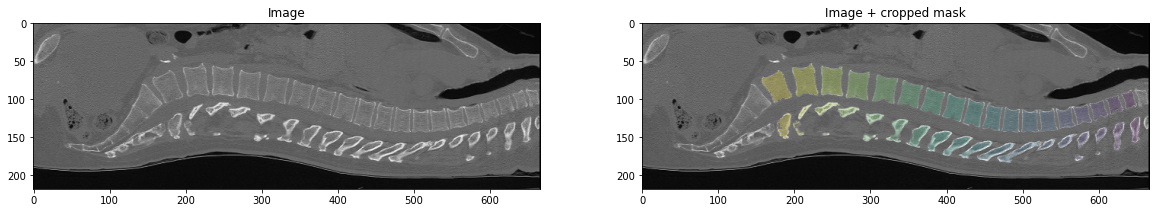

verse276.mha
Original img shape: (61, 218, 613)
Fixed mask shape: (61, 218, 613)


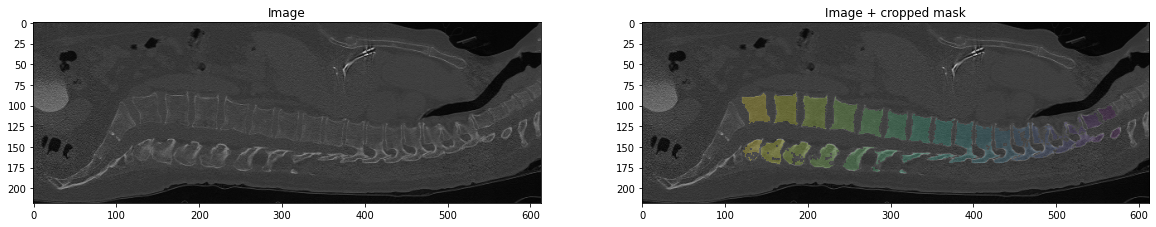

In [51]:
for img_path, msk_path in zip(img_paths, msk_paths):
    # read the image and the predicted mask
    img, header_img = read_image(img_path)
    msk, header_msk = read_image(msk_path)
    file_name = img_path.split('/')[-1]
    
    # filter out non C vertebrae, otherwise the vertebrae get the same color
    msk = np.where(msk < 26, msk, 0)
    plt_msk = np.ma.masked_where(msk == 0, msk)
    
    # mid slice of the image
    mid_slice = img.shape[0] // 2   
    
    # if the shape are not the same, we will crop the mask to the target shape (shape of the orignal image)
    if not(img.shape == msk.shape):  
        if not(file_name in ['verse024.mha', 'verse205.mha', 'verse242.mha']):            # processor reports failure for these images
            print(file_name)
            
            fixed_msk = resample_mask_itk(msk, header_msk['spacing'], header_img['spacing'])
            fixed_msk, metadata = change_direction(image=msk, header=header_msk, new_direction=header_img['direction'], new_origin=header_img['origin'])

            print('Original img shape: {}'.format(img.shape))
            fixed_msk = np.ma.masked_where(fixed_msk == 0, fixed_msk)
            print('Fixed mask shape: {}'.format(fixed_msk.shape)) 
            
            if fixed_msk.shape != img.shape:
                fixed_msk = pad_or_crop_image(fixed_msk, img.shape, align='min')
                print('Cropped mask shape: {}'.format(fixed_msk.shape)) 
                
            fixed_msk = np.ma.masked_where(fixed_msk == 0, fixed_msk)  
            plt.figure(figsize=(20,10))
            plt.subplot(1, 2, 1)
            plt.imshow(img[mid_slice, :, :], cmap='gray')
            plt.title('Image')
            
            plt.subplot(1, 2, 2)
            plt.imshow(img[mid_slice, :, :], cmap='gray')
            plt.imshow(fixed_msk[mid_slice, :, :], alpha=0.25)
            plt.title('Image + cropped mask')
            plt.show()
            
            # store
            write_image(os.path.join(out_dir, file_name), fixed_msk, header_img)
    else:
        write_image(os.path.join(out_dir, file_name), msk, header_msk)